#Stochastic Distribution Comparison

This notebook implements distance computations between the `obtained` and `target distributions`—an essential extension incorporating stochastic uncertainty to account for inherent randomness and variability in the measurement process. Unlike deterministic comparisons, this approach adjusts for the `probabilistic fluctuations` present in both the data and the simulation, enabling a more precise evaluation of distributional differences. This consideration of `stochastic uncertainty` is crucial for robustly assessing similarity or divergence, ensuring the analysis reflects the true statistical nature of the underlying phenomena.

## Setup and Installation

To run the quantum circuit simulation and related analyses in this notebook, ensure you have the required `Python packages` installed.

In [ ]:
!pip install numpy scipy qiskit qiskit_aer matplotlib qiskit_ibm_runtime pylatexenc

In [ ]:
import random
import collections
import pylatexenc
import numpy as np
from qiskit import *
from qiskit_aer import AerSimulator
from matplotlib import pyplot as plt
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import QiskitRuntimeService
from scipy.optimize import minimize
from scipy.stats import norm, binom, wasserstein_distance

##Functions

###Quantum Walk Step: One Peg Galton Board

In [ ]:
def one_peg_galton_board(
    qc: QuantumCircuit,
    control_qubit: QuantumRegister,
    target_q_reg: QuantumRegister,
    center_idx: int,
    j: int,
    is_last_step: bool
):
    """
    Applies one step of the controlled-swaps sequence which illustrates one peg in a certain level forms the core of the
    quantum wala. This function encapsulates the four-gate sequence

    Args:
        qc: The QuantumCircuit to add gates to.
        control_qubit: The qubit controlling the operations.
        target_q_reg: The register on which the walk occurs.
        center_idx: The index of the center qubit in target_q_reg.
        j: The offset from the center for the current step.
        is_last_step: A boolean to prevent adding a final CNOT.
    """
    # Define the three qubits involved in this step
    qubit_A = target_q_reg[center_idx + j - 1]
    qubit_B = target_q_reg[center_idx + j]
    qubit_C = target_q_reg[center_idx + j + 1]

    # The Quantum circuit for 1 peg step
    qc.cswap(control_qubit, qubit_A, qubit_B)
    qc.cx(qubit_B, control_qubit)
    qc.cswap(control_qubit, qubit_B, qubit_C)

    # The final CNOT is omitted on the last step of the inner loop for optimization purpose
    if not is_last_step:
        qc.cx(qubit_C, control_qubit)

###Galton Board Circuit

In [ ]:
def Galton_board_circuit(level: int,Controls : list=None) -> QuantumCircuit:
    """
    Builds the complete quantum galton board circuit in a structured and modular way.

    Args:
        level: No. of levels in Galton board
        Controls: List of value of theta of each level(defalut:It performs hadamard gate)

    Returns:
        The fully constructed Quantum Galton Board Circuit object.
    """
    # If no custom controls are provided, use Hadamard (pi/2 RX) at each level
    if Controls==None:
      Controls=[np.pi/2]*level

    # Check if the number of control angles matches the number of levels
    if len(Controls)!=level:
        raise ValueError("Not optimal Control")

    # 1. SETUP: Define quantum and classical registers
    num_qubits = 2 * (level + 1) # Number of qubits needed for the walk space
    q = QuantumRegister(num_qubits, "q")
    c = ClassicalRegister(level + 1, "c")
    circuit = QuantumCircuit(q, c) # Create the quantum circuit

    # Define key qubit indices
    control_qubit = q[0]
    center_qubit_index = level + 1 # This is the starting position index

    # 2. INITIAL STATE: Prepare the system
    '''Set the qubit at the center_qubit_index to the |1> state.This initializes the walk at the central
      position in the quantum walk space'''

    circuit.x(q[center_qubit_index])

    # 3. ALGORITHM: Build the main logic of the circuit
    for i in range(level):
        circuit.reset(control_qubit)
        circuit.rx(Controls[i],control_qubit)
        indices = list(range(-i, i+1, 2))
        '''Get list of relative position of individual peg circuit relative to center qubit for a particular value of i(level)
           Example:
          - i=0 -> [0]
          - i=1 -> [-1, 1]
          - i=2 -> [-2, 0, 2]
          - i=3 -> [-3,-1,1,3]'''
        # Apply the quantum walk step (one peg operation) for each relevant position in the current level
        for step_index, j in enumerate(indices):
            # Check if this is the last step in the inner loop for optimization
            is_last = (step_index == len(indices) - 1)
            one_peg_galton_board(
                qc=circuit,
                control_qubit=control_qubit,
                target_q_reg=q,
                center_idx=center_qubit_index,
                j=j,
                is_last_step=is_last
            )
    circuit.barrier()

    # 4. MEASUREMENT: Measure the desired qubits to get the result
    qubits_to_measure = [q[i] for i in range(num_qubits) if i % 2 != 0]
    circuit.measure(qubits_to_measure, c) # Measure the selected qubits into the classical register

    return circuit

###Classical galton Board
This function simulates the **classical** version of the `Galton Board`, where balls are released from the top and pass through a fixed number of pin levels, moving randomly to the left or right with equal probability.

In [ ]:
def Classical_galton_board(n_rows: int, n_balls: int):
    """
    Simulate a classical Galton board and return a list of outcomes.

    Args:
        n_rows: Number of peg rows.
        n_balls: Number of balls dropped.

    Returns:
        outcomes: List where each element is the final bin index for a ball.
    """
    outcomes = []

    for _ in range(n_balls):
        position = 0
        for _ in range(n_rows):
            step = random.choice((0, 1))  # left=0, right=1
            position += step
        outcomes.append(position)

    return outcomes

##Noise Model
Importing the Noise Model by connecting to the `IBM Quantum platform` using Qiskit Runtime Service, retrieves the specified backend, and loads its corresponding noise model for realistic quantum circuit simulations.

In [ ]:
Service = QiskitRuntimeService(token='0uXPRBWEy7Xx9LgbO04uJr5VcGa-pt4xd0846FYJQJgf',
                               channel='ibm_quantum_platform',
                               instance='Wiser monte carlo')
Backend = Service.backend("ibm_torino")
noise_model = NoiseModel.from_backend(Backend)

##Quantum hadamard walk

###Target Distribution

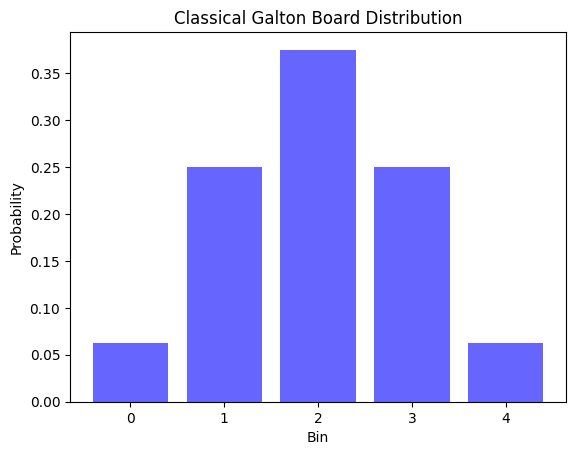

In [ ]:
n = 4  # Number of levels
p = 0.5  # Probability of going right(Un-biased)
Balls = 20000

x = np.arange(0, n + 1)  # Outcomes for the number of right turns (0 to n)
probs = binom.pmf(x, n, p)  # Theoretical binomial probabilities for outcomes

mu = n * p  # Mean of binomial distribution
sigma = np.sqrt(n * p * (1 - p))  # Standard deviation of binomial distribution
Classical_sim_dic = dict(zip(x, probs))  # Map outcomes to probabilities(Have future use)
Classical_sim_measurement_result = Classical_galton_board(n, Balls)  # Simulate Galton board

plt.hist(x, bins=np.arange(-0.5, n + 1.5, 1), weights=probs, alpha=0.6, rwidth=0.8,color='Blue')
plt.xlabel('Bin')
plt.ylabel('Probability')
plt.title('Classical Galton Board Distribution')
plt.xticks(x)
plt.show()

###Quantum Distribution

In [ ]:
#This all should match with target distribution
circuit_level = 4
circuit_controls= None #None:needed it is default hadamard
shot=20000

# Build the circuit
my_circuit = Galton_board_circuit(level=circuit_level)
# Transpile for simulator
simulator = AerSimulator(method='density_matrix',noise_model=noise_model)
transpiled = transpile(my_circuit, simulator,optimization_level=3)

# Execute
job = simulator.run(transpiled, shots=shot, memory=True)
result = job.result()
counts = result.get_counts(0)
Quantum_sim_measurement_result=result.get_memory(my_circuit)

Measurement counts (noise): {'00001': 0.04895, '01000': 0.16975, '10000': 0.04585, '00100': 0.2734, '00010': 0.1864}


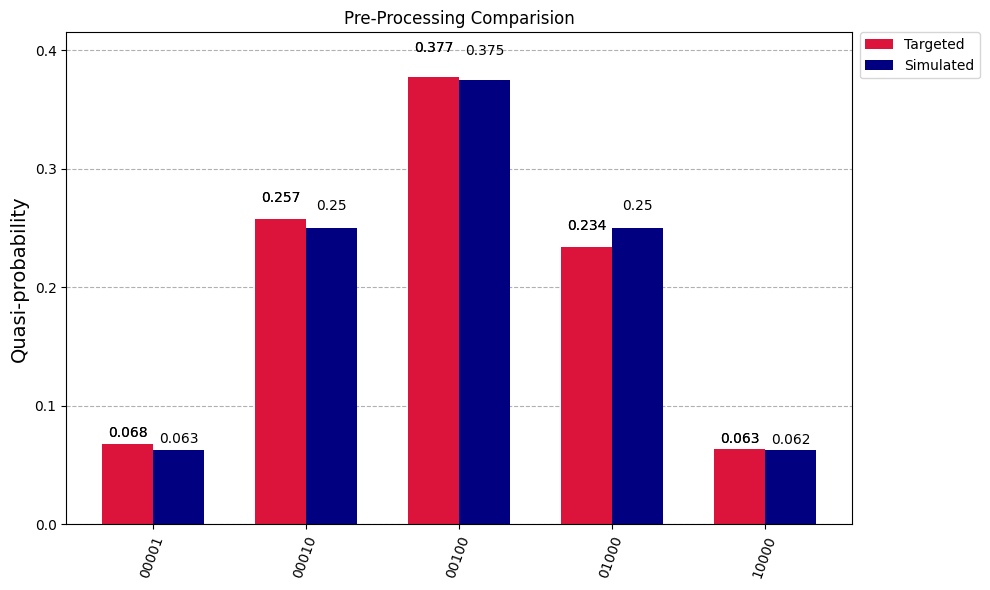

In [ ]:
bitstring_to_int = {'0' * (circuit_level - i) + '1' + '0' * i: i for i in range(circuit_level + 1)}
filtered_data = {k: v for k, v in counts.items() if k in bitstring_to_int}
filtered_data = {k: v / shot for k, v in filtered_data.items()}
Classical_sim_dic = {'0'*(circuit_level-i)+'1'+'0'*i: v for i, (k, v) in enumerate(Classical_sim_dic.items())}
print("Measurement counts (noise):", filtered_data)
plot_histogram([filtered_data,Classical_sim_dic],
               legend=["Targeted", "Simulated"],
               color=['crimson', 'navy'],figsize=(10,6),title="Pre-Processing Comparision")

##Post-Processing

In [ ]:
def histogram_binning(output:list,level:int,block_size=8):
    """
    Processes a list of measurement outcomes (bitstrings) and bins them
    by summing up the integer value of mapped outcomes within specified blocks.

    Args:
        output: A list of measurement outcome bitstrings.
        level: The number of levels in the Galton board, used for bitstring to integer mapping.
        block_size: The number of outcomes to group together for summation.(Defalut:8)

    Returns:
        A list of summed integer values for each block of outcomes.
    """
    shots=len(output) # Get the total number of measurement shots
    bitstring_to_int = {'0' * (level - i) + '1' + '0' * i: i for i in range(level+1)}

    # Map each outcome bitstring to its corresponding integer value using the defined mapping.
    mapped_outputs = np.array([bitstring_to_int.get(o, 0) for o in output])

    # This creates a new list where each element is the sum of mapped outcomes in a block.
    return [sum(mapped_outputs[i:i+block_size]) for i in range(0, shots, block_size)]

/tmp/ipython-input-2494384907.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, Cla_pdf, 'k', linewidth=2, label=f'Targeted Normal fit\nμ={cla_mu:.2f}, σ={cla_sigma:.2f}',color='red')
/tmp/ipython-input-2494384907.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, Qu_pdf, 'k', linewidth=2, label=f'Quantum Normal fit\nμ={Qu_mu:.2f}, σ={Qu_sigma:.2f}',color='blue')


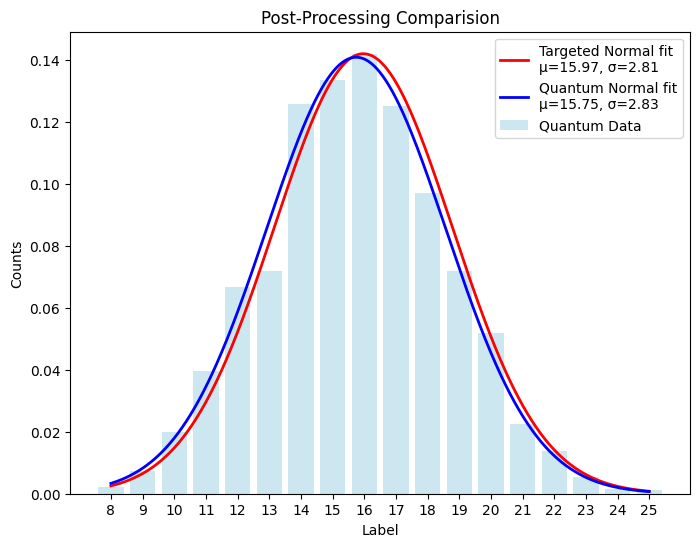

In [ ]:
filtered_measurement_results=[x for x in Quantum_sim_measurement_result if x in bitstring_to_int]
# your histogram data
Qu_binning_data = histogram_binning(filtered_measurement_results, circuit_level)
Cla_binning_data = [sum(Classical_sim_measurement_result[i:i+8]) for i in range(0, len(Classical_sim_measurement_result), 8)]#No bitstring_to int needed

#sorting and counting Qu_binning_data to plot histogram
frequency = collections.Counter(Qu_binning_data)
sorted_labels = sorted(frequency.keys())
sorted_values = [frequency[label] for label in sorted_labels]
sorted_values=[x / len(Qu_binning_data) for x in sorted_values]
chart_labels = np.array(sorted_labels)


# Plot histogram
plt.figure(figsize=(8, 6))
plt.bar(chart_labels, sorted_values, color='lightblue', alpha=0.6, label='Quantum Data')

# Fit normal distribution parameters (mean, std) from the data
Qu_mu, Qu_sigma = norm.fit(Qu_binning_data)
cla_mu, cla_sigma = norm.fit(Cla_binning_data)  # uses raw measurement results

# Create smooth curve for the normal distribution
x = np.linspace(min(chart_labels), max(chart_labels), 500)
Cla_pdf = norm.pdf(x, cla_mu, cla_sigma)
Qu_pdf = norm.pdf(x, Qu_mu, Qu_sigma)

# Plot normal curve
plt.plot(x, Cla_pdf, 'k', linewidth=2, label=f'Targeted Normal fit\nμ={cla_mu:.2f}, σ={cla_sigma:.2f}',color='red')
plt.plot(x, Qu_pdf, 'k', linewidth=2, label=f'Quantum Normal fit\nμ={Qu_mu:.2f}, σ={Qu_sigma:.2f}',color='blue')
plt.xlabel("Label")
plt.ylabel("Counts")
plt.title("Post-Processing Comparision")
plt.xticks(np.arange(min(chart_labels), max(chart_labels) + 1, 1))
plt.legend()
plt.show()

##Wasserstein distance

`Wasserstein distance` is a way to measure how different two probability distributions are. It tells us the `minimum "effort"` needed to transform one distribution into the other. This distance is widely used in fields like `machine learning`, `image analysis`, and `statistics` to compare complex data distributions, solve optimization problems. Essentially, it provides a meaningful measure of difference that captures the shape and spread of data, beyond `simple point-by-point` comparisons.

In [ ]:
def wasserstein_distance_gaussian(mu1, sigma1, mu2, sigma2):
    """
    Calculate the Wasserstein distance between two Gaussian distributions.

    Parameters:
        mu1, sigma1 : mean and standard deviation of the first Gaussian
        mu2, sigma2 : mean and standard deviation of the second Gaussian

    Returns:
        dis : computed Wasserstein distance
    """

    # Define x-range to capture most of both Gaussian curves (±4σ covers ~99.99% of data)
    x_min = min(mu1 - 4*sigma1, mu2 - 4*sigma2)
    x_max = max(mu1 + 4*sigma1, mu2 + 4*sigma2)
    x = np.linspace(x_min, x_max, 1000)  # dense sampling for smooth PDFs

    # Compute Gaussian probability density function (PDF) values
    pdf1 = 1/(sigma1 * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu1) / sigma1) ** 2)
    pdf2 = 1/(sigma2 * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu2) / sigma2) ** 2)

    # Normalize PDFs so they sum to 1 (helps avoid floating-point accumulation errors)
    pdf1 /= np.sum(pdf1)
    pdf2 /= np.sum(pdf2)

    # Calculate Wasserstein distance for discrete distributions defined by (x, pdf)
    dis = wasserstein_distance(x, x, u_weights=pdf1, v_weights=pdf2)

    return dis


# Define means and standard deviations of target and simulated distributions
mu_target = Qu_mu
sigma_target = Qu_sigma
mu_sim = cla_mu
sigma_sim = cla_sigma

# Compute Wasserstein distance between the two Gaussian distributions
W_dis = wasserstein_distance_gaussian(mu_target, sigma_target, mu_sim, sigma_sim)

# Display the result
print("Wasserstein distance:", W_dis)


Wasserstein distance: 0.22644951806023436


##Bootstrap Analysis of Wasserstein Distances

This code snippet performs a `bootstrap resampling` procedure to assess the statistical changes of the Wasserstein distance between the `Quantum distribution` of simulated Galton board outcomes and a `target probability distribution`. The Galton board models the random paths of balls through a triangular array of pins, producing outcomes that follow a `stochastic binomial`-like distribution.

From the bootstrap distribution of Wasserstein distances, the code calculates several key statistics:

  - The `95% confidence` interval (CI) represents the range within which the true Wasserstein distance would lie with 95% confidence. This interval is important because it provides a robust measure of precision and reliability for the distance estimate—giving insight into whether observed differences are statistically significant or could be due to chance fluctuations.

  - The `mean` distance summarizes the average difference observed under resampling.

  - The `standard deviation` measures the spread of this difference, reflecting uncertainty.




Mean Wasserstein Distance (Bootstrap): 0.0340
Standard Deviation: 0.0073
95% Confidence Interval: [0.0201, 0.0482]


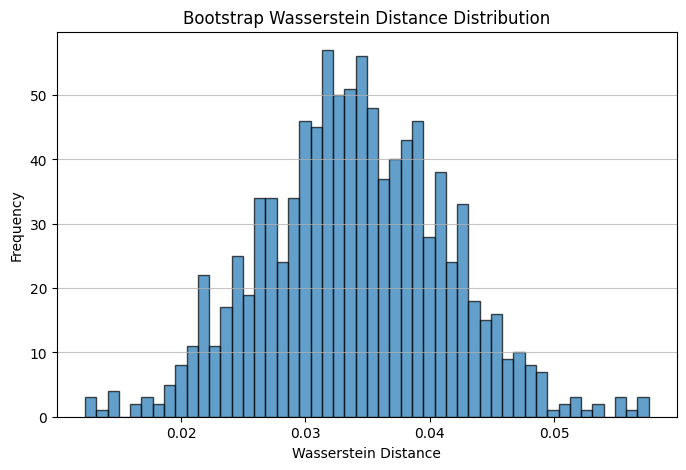

In [ ]:
# Define mappings between integer positions and bitstring representations
int_to_bitstring = {i: '0' * (n - i) + '1' + '0' * i for i in range(n + 1)}
bitstring_to_int = {v: k for k, v in int_to_bitstring.items()}

# Create target histogram with bitstring keys
target_histogram = {int_to_bitstring[i]: probs[i] for i in range(n + 1)}

num_bootstrap_samples = 1000 #No. of samples
bootstrap_distances = []

original_shots = len(Quantum_sim_measurement_result)
all_outcomes = list(target_histogram.keys())
all_outcome_ints = [bitstring_to_int[outcome] for outcome in all_outcomes]

for _ in range(num_bootstrap_samples):
    # Resample with replacement
    resampled = random.choices(Quantum_sim_measurement_result, k=original_shots)
    resampled_counts = collections.Counter(resampled)

    # Probability vectors for resampled and target distributions
    resampled_weights = [resampled_counts.get(outcome, 0) for outcome in all_outcomes]
    total_counts = sum(resampled_weights)
    resampled_probs = np.array(resampled_weights) / total_counts if total_counts > 0 else np.zeros_like(resampled_weights)
    target_probs = [target_histogram[outcome] for outcome in all_outcomes]

    # Calculate Wasserstein distance using integer mapping
    dist = wasserstein_distance(all_outcome_ints, all_outcome_ints,
                               u_weights=resampled_probs, v_weights=target_probs)
    bootstrap_distances.append(dist)

# Calculate statistics on bootstrap distances
mean_dist = np.mean(bootstrap_distances)
std_dist = np.std(bootstrap_distances)
sorted_dist = np.sort(bootstrap_distances)
lower_ci = sorted_dist[int(0.025 * num_bootstrap_samples)]
upper_ci = sorted_dist[int(0.975 * num_bootstrap_samples)]

print(f"\nMean Wasserstein Distance (Bootstrap): {mean_dist:.4f}")
print(f"Standard Deviation: {std_dist:.4f}")
print(f"95% Confidence Interval: [{lower_ci:.4f}, {upper_ci:.4f}]")

# Optional histogram plot of bootstrap distances
plt.figure(figsize=(8, 5))
plt.hist(bootstrap_distances, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel("Wasserstein Distance")
plt.ylabel("Frequency")
plt.title("Bootstrap Wasserstein Distance Distribution")
plt.grid(axis='y', alpha=0.75)
plt.show()

Observations from Bootstrap Analysis of Wasserstein Distances
- **Mean Wasserstein Distance**:
This relatively small value indicates that, on average, the empirical distribution from the Galton board simulation closely matches the theoretical target distribution. A smaller Wasserstein distance implies greater similarity between these distributions.

- **Standard Deviation**:
The low standard deviation reflects consistent bootstrap estimates of the Wasserstein distance, suggesting stable and reliable measurement across the resampled datasets.

- **95% Confidence Interval**:
The narrow confidence interval implies that the true Wasserstein distance lies within this range with 95% confidence. Being close to zero, it confirms that the empirical distribution approximates the target distribution well with minimal uncertainty.